In [1]:
!pip install networkx
!pip install threadpool

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [1]:
import networkx as nx
from queue import Queue

In [2]:
import numba
import time
from queue import Queue
from tqdm import tqdm

def my_task(params):
    G = params['G']
    s = params['s']
    
    CB = dict.fromkeys(G, 0.0)
    
    PreNode = {w : [] for w in G.nodes()}  # 用于存储每个节点的前置节点
    dist = dict.fromkeys(G, None)          # 用于存储从s出发到一个节点的距离
    sigma = dict.fromkeys(G, 0.0)          # 用于存储从s出发到一个节点的最短路径个
    delta = dict.fromkeys(G, 0.0)          

    sigma[s] = 1  # 起始节点的sigma(s)为1
    dist[s] = 0   # 起始节点到自己的路径长度为0

    S = []        # 用于优先的遍历顺序，因为后面需要根据遍历顺序反向逐步计算delta
    Q = Queue()   # 用于宽度有限搜索
    Q.put(s)      # 将初始节点放入队列中

    while not Q.empty():
        v = Q.get()                         # 从队列中取出一个节点
        S.append(v)                         # 将其保存在遍历顺序记录数组中

        for w in G.neighbors(v):           
            if dist[w] is None:             # 如果该节点的dist为None, 那么说明它是第一次被访问
                Q.put(w)                    #   此时将其放入遍历队列
                dist[w] = dist[v] + 1       #   同时将其dist置为前一个节点的dist+1

            if dist[w] == dist[v] + 1:      # 如果上一个在这个节点的最短路径上
                sigma[w] += sigma[v]        #   这个节点的sigma加上上个节点的sigma
                PreNode[w].append(v)        #   同时将上个节点记录到这个节点的前置节点列表中

    for w in S[::-1]:                       # 对记录反序遍历
        for v in PreNode[w]:                # 从后往前计算delta
            delta[v] += sigma[v] / sigma[w] * (1 + delta[w])

        if w != s:
            CB[w] += delta[w]
    
    return CB

In [3]:
def calculate_betweenness(G, pool):
    params = [{"s": s, "G": G} for s in G.nodes()]
    
    results = pool.map(my_task, params)
    
    CB = dict.fromkeys(G, 0.0)
    
    for v in CB:
        for result in results:
            CB[v] += result[v]
        CB[v] /= 2.0    # 因为从s到t 和 t到s计算了两次，因此Betweenness需要除以2
    
    return CB

In [4]:
def test(num_nodes, num_edges_per_node, pool):
    G = nx.random_graphs.barabasi_albert_graph(num_nodes, num_edges_per_node)
    
    time_start = time.time()     # 开始计时
    BC = calculate_betweenness(G, pool)
    time_end = time.time()       # 结束计时

    time_cost = time_end - time_start
    return time_cost

In [5]:
import threading
from multiprocessing import Pool #多线程版本

In [6]:
from tqdm import tnrange
time_cost_list = []
for n_process in tnrange(1, 21):
    pool = Pool(processes=n_process)
    time_cost = test(4000, 10, pool)
    time_cost_list.append(time_cost)

Text(0, 0.5, 'Speed up')

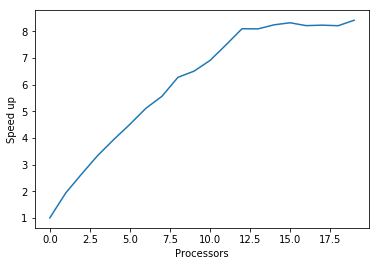

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

time_cost_list2 = [time_cost_list[0] / t for t in time_cost_list]

plt.plot(time_cost_list2)
plt.xlabel("Processors")
plt.ylabel("Speed up")